In [1]:
'''
TOP 5 BALANCED MODELS

Type	Model	Loss	Validation Loss	Total Area	Avg KL div
Balanced	L27_E22_20_B16_D20_22	0.005998428	0.006721942	1.678734815	0.043755358
Balanced	L27_E22_20_B18_D18_20	0.006337718	0.007222764	1.67867217	0.046867523
Balanced	L27_E20_18_B18_D14_16	0.007929437	0.008441048	1.669568182	0.047048626
Balanced	L27_E20_18_B16_D20_22	0.007419921	0.008254252	1.703921669	0.048325082
Balanced	L27_E22_20_B18_D20_22	0.007805503	0.008784806	1.723715099	0.049680205
'''

# Notebook for : L27_E22_20_B16_D20_22

'\nTOP 5 BALANCED MODELS\n\nType\tModel\tLoss\tValidation Loss\tTotal Area\tAvg KL div\nBalanced\tL27_E22_20_B16_D20_22\t0.005998428\t0.006721942\t1.678734815\t0.043755358\nBalanced\tL27_E22_20_B18_D18_20\t0.006337718\t0.007222764\t1.67867217\t0.046867523\nBalanced\tL27_E20_18_B18_D14_16\t0.007929437\t0.008441048\t1.669568182\t0.047048626\nBalanced\tL27_E20_18_B16_D20_22\t0.007419921\t0.008254252\t1.703921669\t0.048325082\nBalanced\tL27_E22_20_B18_D20_22\t0.007805503\t0.008784806\t1.723715099\t0.049680205\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde, entropy  

In [2]:
original_df = pd.read_csv("L27_E22_20_B16_D20_22_Original_minority_data.csv")   
original_df.drop('class', axis=1, inplace=True)
synthetic_df = pd.read_csv("L27_E22_20_B16_D20_22_Synthetic_minority_data.csv") 
synthetic_df.drop('class', axis=1, inplace=True)

In [3]:
class Duplicates:
    def __init__(self, original_df, synthetic_df):
        self.original_df = original_df
        self.synthetic_df = synthetic_df
        self.combined_df = pd.concat([self.original_df, self.synthetic_df], axis=0)

        if self.original_df.shape[1] != self.synthetic_df.shape[1]:
            raise Exception("The number of columns in the original and synthetic datasets must match, but they are different ", self.original_df.shape[1], self.synthetic_df.shape[1])
        
        if self.original_df.shape[0] != self.synthetic_df.shape[0]:
            raise Exception("The number of rows in the original and synthetic datasets are different ", self.original_df.shape[0], self.synthetic_df.shape[0])
        
    def identify_duplicates(self):
        num_duplicates_original_df = self.original_df.duplicated().sum()
        num_duplicates_synthetic_df = self.synthetic_df.duplicated().sum()
        rows_present_in_original = self.synthetic_df.isin(self.original_df.to_dict(orient='list')).all(axis=1)
        num_rows_present = rows_present_in_original.sum()

        print("Number of duplicates in original_df:", num_duplicates_original_df)
        print("Number of duplicates in synthetic_df:", num_duplicates_synthetic_df)
        print("Number of rows in synthetic_df present in original_df:", num_rows_present)    

    
    def calculate_similarity(self, threshold):
        #A row is said to be similar, if all the values of the different columns 
        # in that row are within threshold% deviation of the values in same columns for a different row. 
        def get_similar_df(df1, threshold, **kwargs):

            df2 = kwargs.get('df2', None)
            if df2 is None:
                df2 = df1.copy()

            similar_rows_count = 0
            #similar_rows = []
            for i in range(len(df1)):
                for j in range(i+1, len(df1)):
                    row1, row2 = df1.iloc[i], df2.iloc[j]

                    if (row1 == 0).any() or (row2 == 0).any() or (row1.isna().any()) or (row2.isna().any()):
                        continue

                    deviation = abs((row1 - row2) / row1)
                    if (deviation <= threshold).all():
                        #similar_rows.append((row1.values, row2.values))
                        similar_rows_count += 1             
            return similar_rows_count    

        original_df_similarity = get_similar_df(self.original_df, threshold)
        print(f"Total number of similar rows in original_df: {original_df_similarity}")
        print(f"Duplicate ratio in original_df: {original_df_similarity / self.original_df.shape[0]:.3f}")

        synthetic_df_similarity = get_similar_df(self.synthetic_df, threshold)
        print(f"Total number of similar rows in synthetic_df: {synthetic_df_similarity}")
        print(f"Duplicate ratio in synthetic_df: {synthetic_df_similarity / self.synthetic_df.shape[0]:.3f}")

        synthetic_original_similarity = get_similar_df(self.original_df, threshold, df2=self.synthetic_df)
        print(f"Total number of similar synthetic_df rows in original_df: {synthetic_original_similarity}")
        print(f"Duplicate ratio in similar synthetic_df rows in original_df: {synthetic_original_similarity / self.combined_df.shape[0]:.3f}")

class Analyze:
    def __init__(self, original_df, synthetic_df):
        self.df1 = original_df
        self.df2 = synthetic_df

        if self.df1.shape[1] != self.df2.shape[1]:
            raise Exception("The number of columns in the original and synthetic datasets must match")
        
        if self.df1.shape[0] != self.df2.shape[0]:
            raise Exception("The number of rows in the original and synthetic datasets are different ", self.df1.shape[0], self.df2.shape[0])

    def meanAndStd(self) -> pd.DataFrame:
        output = {}
        for column in self.df1.columns:
            mean_df1 = self.df1[column].mean()
            std_df1  = self.df1[column].std()
            mean_df2 = self.df2[column].mean()
            std_df2  = self.df2[column].std()
            meandiff = abs(mean_df1 - mean_df2)

            output[column] = {'Mean_diff': meandiff,
                            'Mean_original_df': mean_df1, 'Mean_synthetic_df': mean_df2,
                            'Std_original_df' : std_df1,  'Std_synthetic_df' : std_df2}
        return pd.DataFrame(output).transpose().sort_values(by='Mean_diff', ascending=False)
    
    def plotHeatMaps(self,annot=False) -> None:
        _ , axes = plt.subplots(1, 2, figsize=(18, 10))
        sns.heatmap(self.df1.corr(), annot=annot, cmap='viridis', ax=axes[0])
        axes[0].set_title('Original')

        sns.heatmap(self.df2.corr(), annot=annot, cmap='viridis', ax=axes[1])
        axes[1].set_title('Synthetic')
        plt.tight_layout()
        plt.show()

    def plotScatterPlots(self, start_index, end_index) -> None:
        num_columns = len(self.df1.columns)
        num_rows = (num_columns + 4) // 5  

        fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
        for i, column in enumerate(self.df1.columns):
            row_idx = i // 5
            col_idx = i % 5

            axs[row_idx, col_idx].scatter(self.df1.index[start_index:end_index], self.df1[column][start_index:end_index], color='red', label='original_df')
            axs[row_idx, col_idx].scatter(self.df2.index[start_index:end_index], self.df2[column][start_index:end_index], color='blue', label='synthetic_df')

            axs[row_idx, col_idx].set_title(f"Scatter Plot: {column}")
            axs[row_idx, col_idx].set_xlabel("Index")
            axs[row_idx, col_idx].set_ylabel(column)

            axs[row_idx, col_idx].legend()

        for i in range(num_columns, num_rows * 5):
            row_idx = i // 5
            col_idx = i % 5
            fig.delaxes(axs[row_idx, col_idx])

        plt.tight_layout()
        plt.show()

        for i in range(num_columns, num_rows * 5):
            row_idx = i // 5
            col_idx = i % 5
            fig.delaxes(axs[row_idx, col_idx])

        plt.tight_layout()
        plt.show()
    

    def plot_density(self):
        num_columns = len(self.df2.columns)
        num_rows = int(np.ceil(num_columns / 5))
        fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))

        highlighted_areas = {} 
        kl_divergences = {}  

        for i, column in enumerate(self.df1.columns):
            row = i // 5
            col = i % 5
            ax = axes[row, col] if num_rows > 1 else axes[col]

            sns.kdeplot(data=self.df1[column], color='blue', label='original_df', ax=ax)
            sns.kdeplot(data=self.df2[column], color='green', label='synthetic_df', ax=ax)

            # Fill between the curves
            x = np.linspace(0, 1, 1000)  
            kde_original = gaussian_kde(self.df1[column])
            kde_synthetic = gaussian_kde(self.df2[column])
            y1 = kde_original(x)
            y2 = kde_synthetic(x)
            ax.fill_between(x, y1, y2, where=(y1 > y2), interpolate=True, color='lightcoral', alpha=0.3)
            ax.fill_between(x, y1, y2, where=(y1 <= y2), interpolate=True, color='lightgreen', alpha=0.3)

            # Calculate and store the highlighted area for the column
            highlighted_area = np.sum(np.maximum(y1 - y2, 0) * np.diff(x)[0])
            highlighted_areas[column] = highlighted_area

            # Calculate and store the KL divergence for the column
            kl_divergence = entropy(y1, y2) # REF https://www.kaggle.com/code/nhan1212/some-statistical-distances
            kl_divergences[column] = kl_divergence

            ax.set_title(column)
            ax.set_xlabel(column)
            ax.set_xlim(0, 1)
            ax.legend()

        plt.tight_layout()
        plt.show()

        total_highlighted_area = np.sum(list(highlighted_areas.values()))
        total_kl_divergence = np.sum(list(kl_divergences.values()))

        for column, area in highlighted_areas.items():
            divergence = kl_divergences[column]
            print(f"{column}: {area:.2f}, {divergence:.6f}")

        print(f"Total highlighted area: {total_highlighted_area:.2f}")
        print(f"Average KL divergence: {total_kl_divergence / num_columns:.6f}")        
    

In [5]:
dup = Duplicates(original_df, synthetic_df)
dup.identify_duplicates()

Number of duplicates in original_df: 1
Number of duplicates in synthetic_df: 1
Number of rows in synthetic_df present in original_df: 0


In [6]:
dup.calculate_similarity(threshold=0.1)

Total number of similar rows in original_df: 1
Duplicate ratio in original_df: 0.001
Total number of similar rows in synthetic_df: 1
Duplicate ratio in synthetic_df: 0.001
Total number of similar synthetic_df rows in original_df: 0
Duplicate ratio in similar synthetic_df rows in original_df: 0.000


In [7]:
dup.calculate_similarity(threshold=0.25)

Total number of similar rows in original_df: 1
Duplicate ratio in original_df: 0.001
Total number of similar rows in synthetic_df: 3
Duplicate ratio in synthetic_df: 0.003
Total number of similar synthetic_df rows in original_df: 0
Duplicate ratio in similar synthetic_df rows in original_df: 0.000


In [11]:
dup.calculate_similarity(threshold=0.50)

Total number of similar rows in original_df: 18
Duplicate ratio in original_df: 0.016
Total number of similar rows in synthetic_df: 289
Duplicate ratio in synthetic_df: 0.254
Total number of similar synthetic_df rows in original_df: 24
Duplicate ratio in similar synthetic_df rows in original_df: 0.011


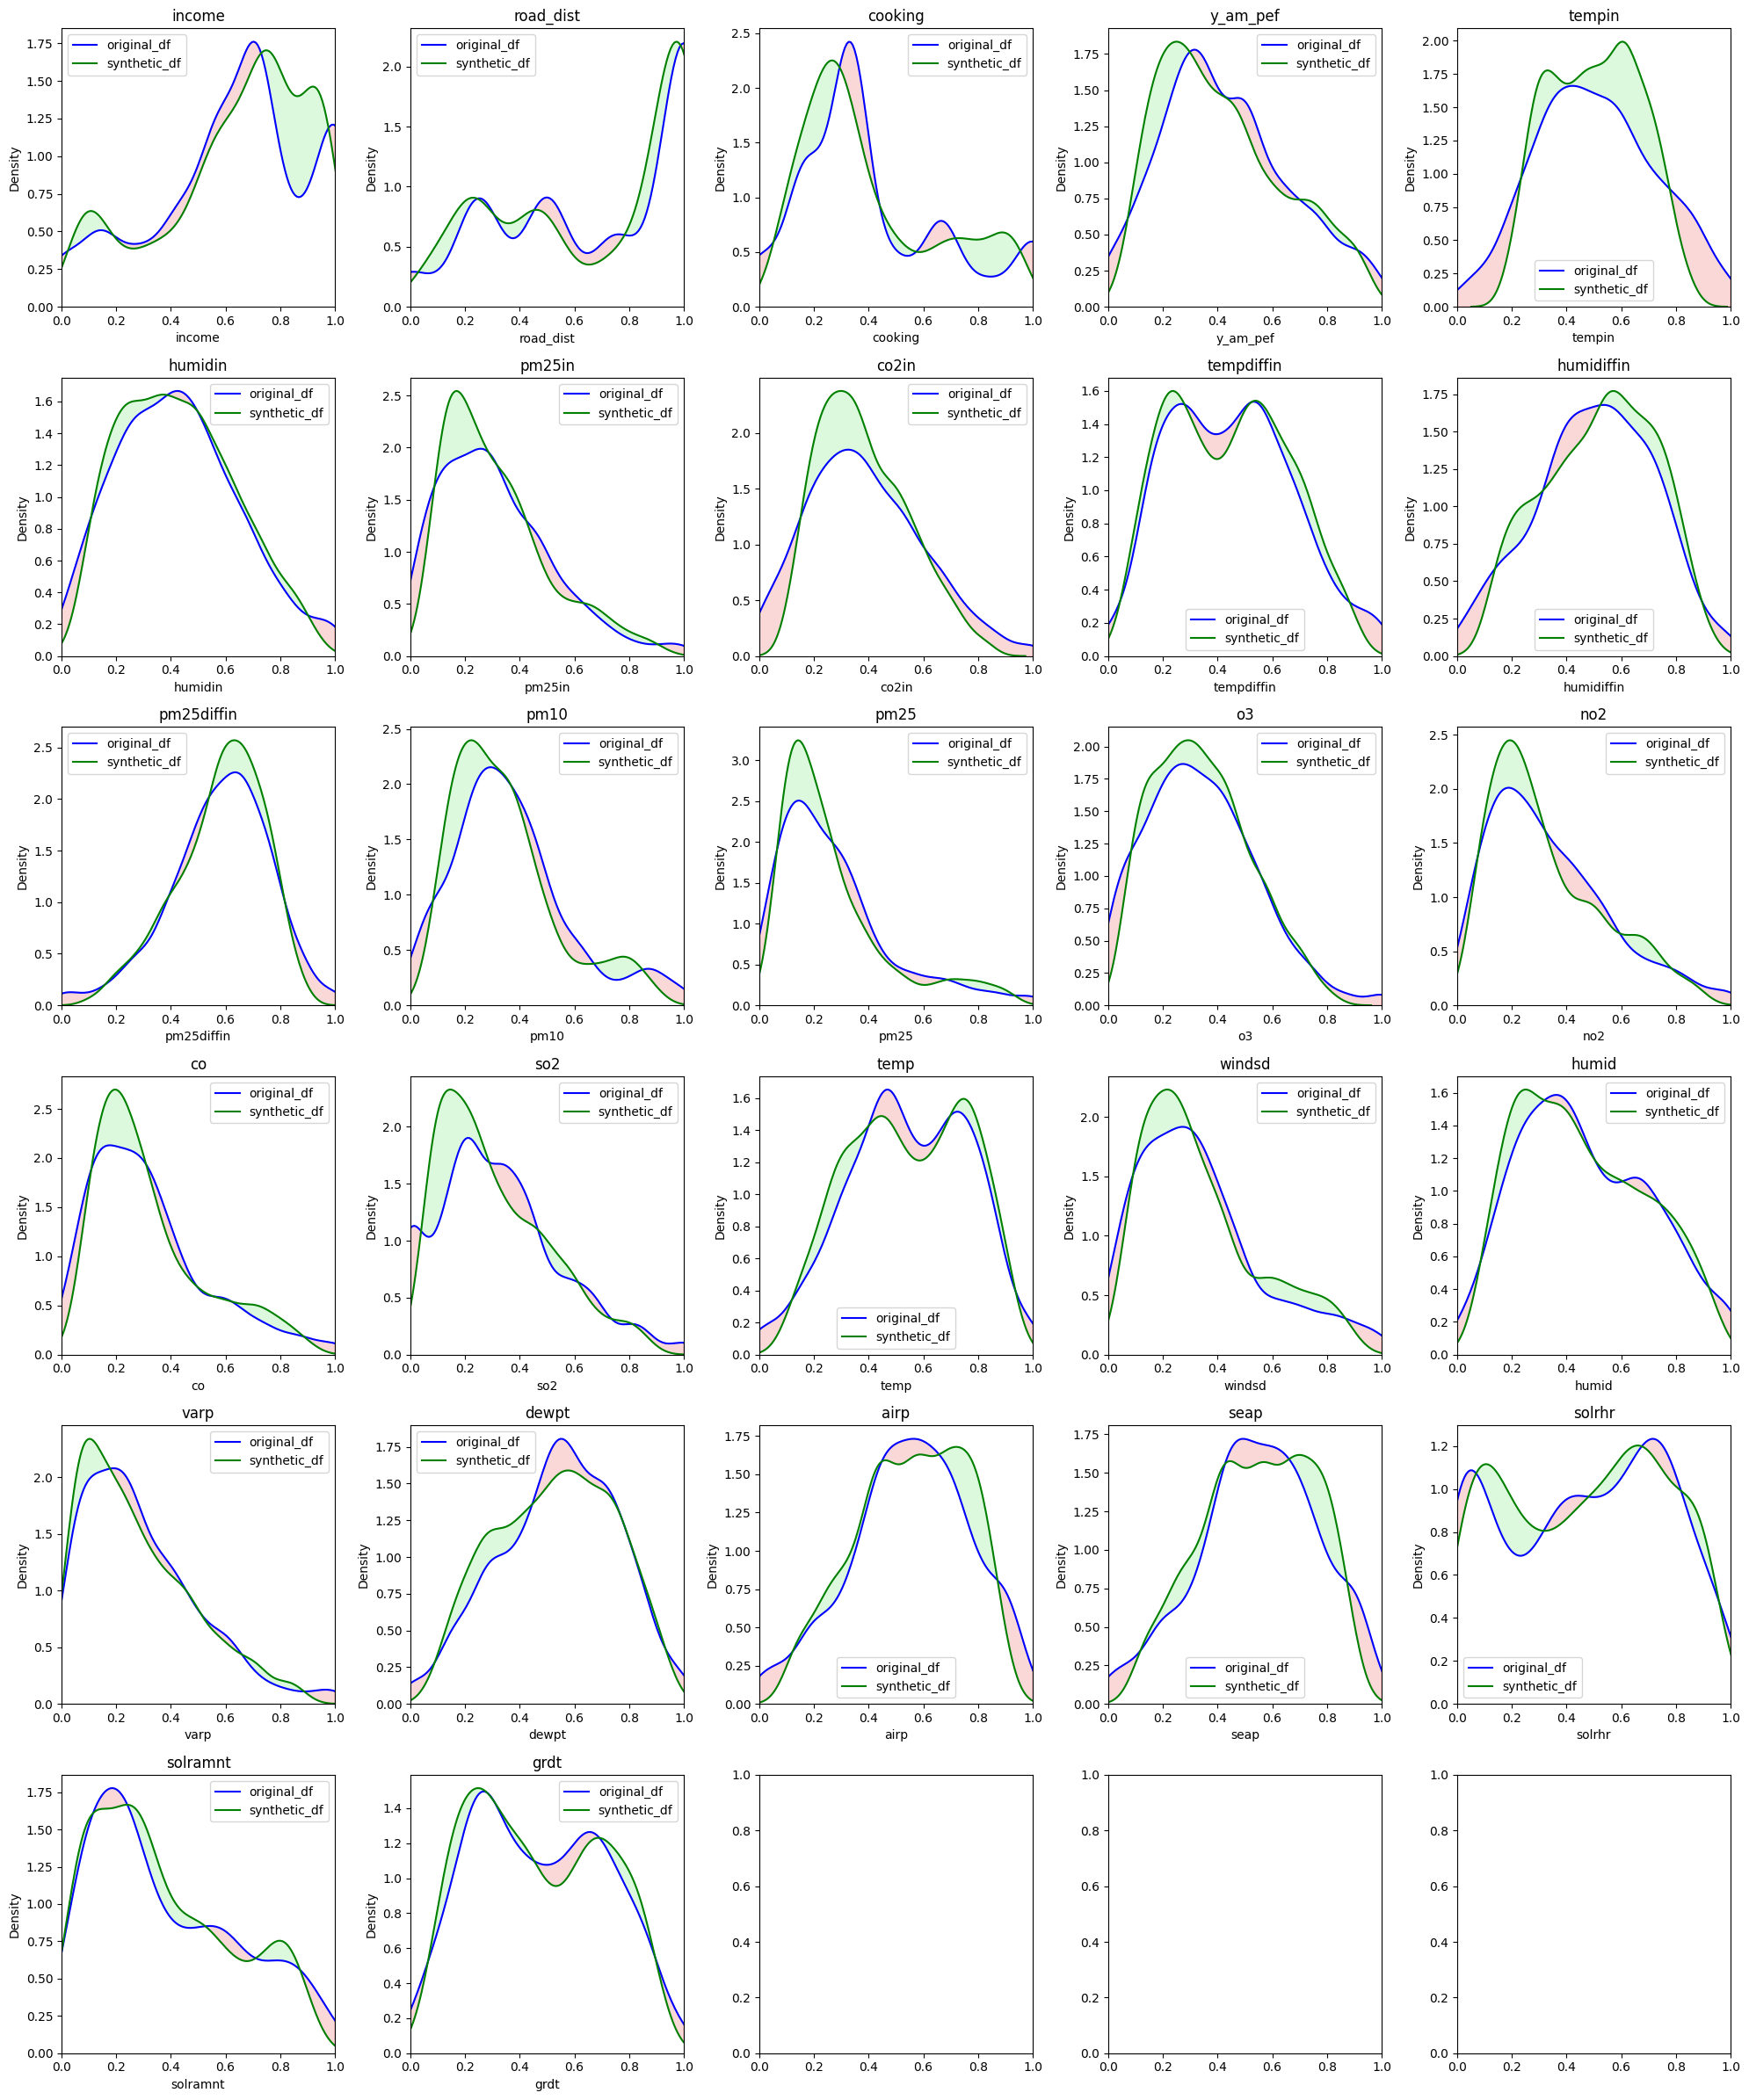

income: 0.06, 0.032142
road_dist: 0.04, 0.025005
cooking: 0.09, 0.045250
y_am_pef: 0.06, 0.019677
tempin: 0.14, 0.311989
humidin: 0.03, 0.015761
pm25in: 0.07, 0.032037
co2in: 0.11, 0.137597
tempdiffin: 0.04, 0.018537
humidiffin: 0.07, 0.035618
pm25diffin: 0.06, 0.049431
pm10: 0.10, 0.055352
pm25: 0.08, 0.026955
o3: 0.04, 0.051669
no2: 0.07, 0.025550
co: 0.07, 0.030340
so2: 0.07, 0.049712
temp: 0.05, 0.018356
windsd: 0.06, 0.029531
humid: 0.03, 0.009266
varp: 0.05, 0.022369
dewpt: 0.05, 0.012693
airp: 0.07, 0.051869
seap: 0.07, 0.046710
solrhr: 0.03, 0.007494
solramnt: 0.04, 0.012987
grdt: 0.03, 0.007498
Total highlighted area: 1.68
Average KL divergence: 0.043755


In [8]:
obj = Analyze(original_df, synthetic_df)
obj.plot_density()

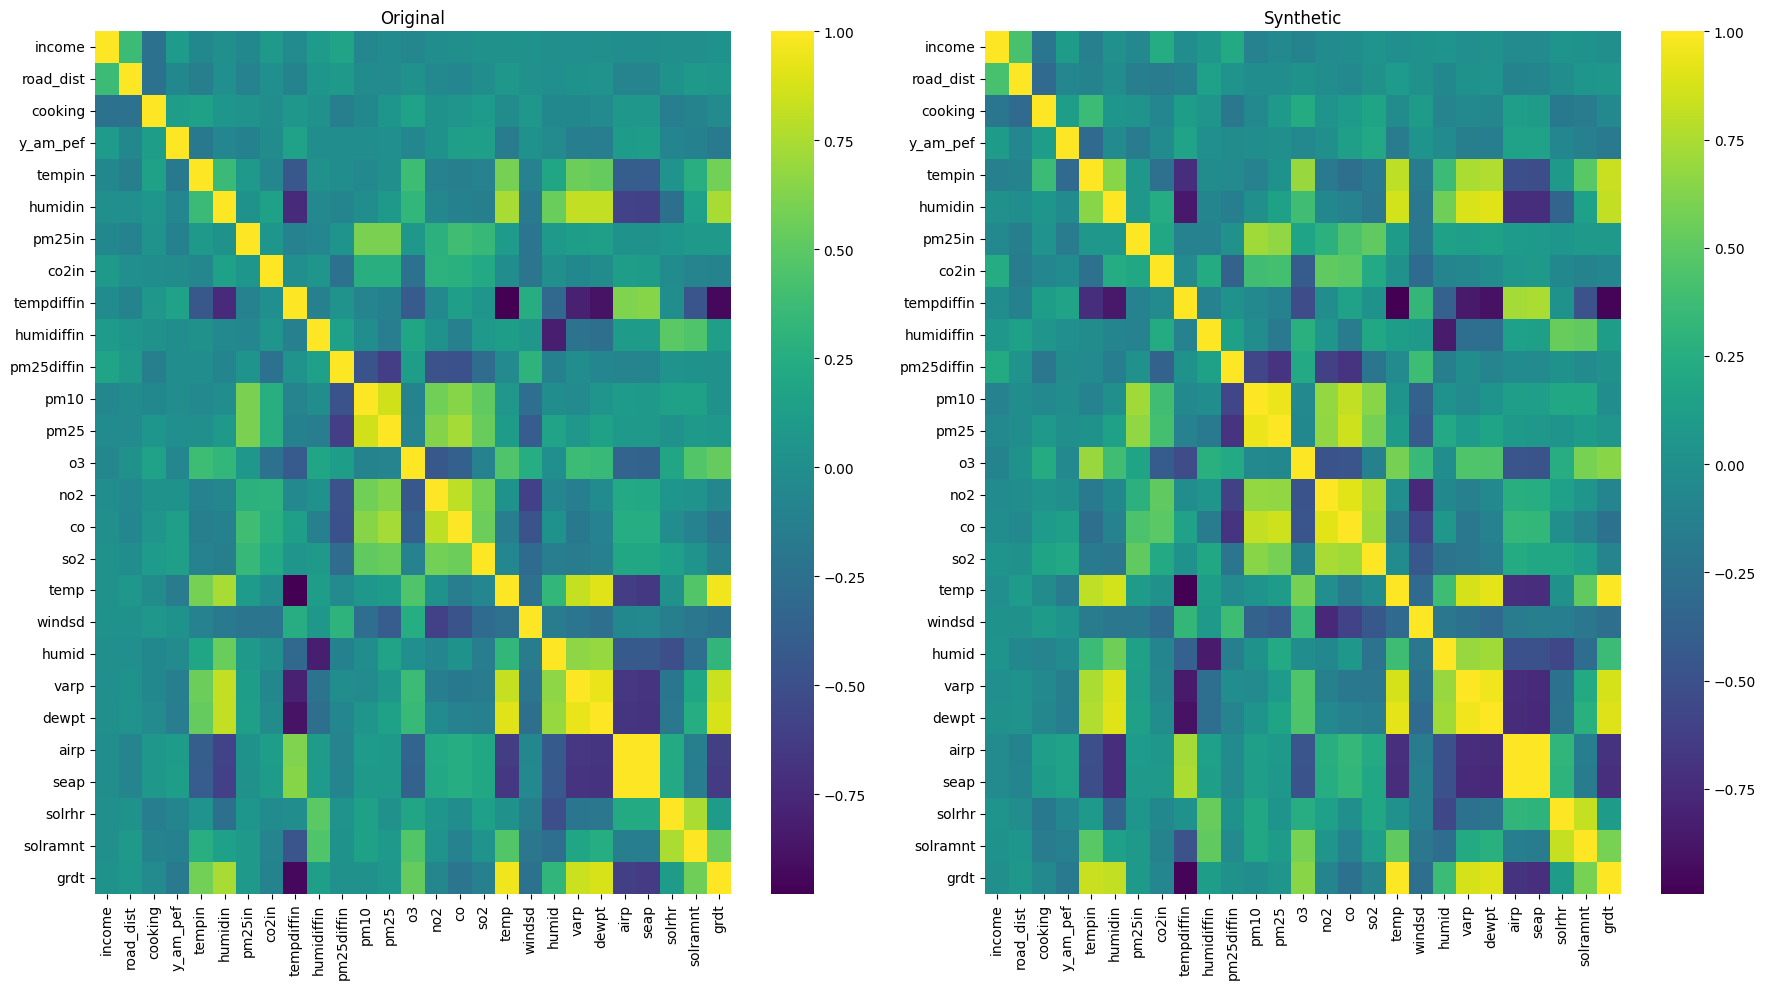

In [9]:
obj.plotHeatMaps(annot=False)

In [10]:
obj.meanAndStd()

,Mean_diff,Mean_original_df,Mean_synthetic_df,Std_original_df,Std_synthetic_df
pm10,0.019630,0.364241,0.344611,0.214467,0.191526
humidiffin,0.015521,0.505331,0.520851,0.215609,0.200534
varp,0.014532,0.293001,0.278469,0.212729,0.203719
dewpt,0.013117,0.541337,0.528220,0.217559,0.212925
solramnt,0.012948,0.383861,0.370913,0.269445,0.251998
y_am_pef,0.011347,0.429845,0.418498,0.234906,0.224722
humid,0.010868,0.467403,0.456535,0.241009,0.228911
no2,0.010080,0.337537,0.327457,0.220364,0.204285
road_dist,0.009513,0.681179,0.671666,0.337865,0.329858
so2,0.007920,0.316427,0.308507,0.228177,0.198377


In [4]:
#%%capture
#!pip install -U gretel-client

from gretel_client.config import RunnerMode
from gretel_client.evaluation.quality_report import QualityReport
from gretel_client import configure_session


# Specify your Gretel API Key

pd.set_option("max_colwidth", None)
configure_session(api_key="prompt", cache="yes", validate=True)

# Create a Quality Report
report = QualityReport(data_source=synthetic_df, ref_data=original_df)
print(report.run())

# Synthetic Data Quality Score (SQS)
print(report.peek())

Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.
Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.
Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.


Using endpoint https://api.gretel.cloud
Logged in as sbhuvaj@gmail.com ✅
None
{'raw_score': 83.82962962962962, 'grade': 'Excellent', 'score': 83}


In [5]:
report.as_dict

{'left_rows': 1137,
 'left_cols': 27,
 'right_rows': 1137,
 'right_cols': 27,
 'fields': [{'name': 'cooking',
   'left_field_features': {'name': 'cooking',
    'type': 'numeric',
    'count': 1137,
    'unique_count': 7,
    'unique_percent': 0.6157,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 3,
    'max_str_length': 5,
    'avg_str_length': 4.5339,
    'min_value': 1,
    'max_value': 1.0,
    'min_precision': 0,
    'max_precision': 3},
   'right_field_features': {'name': 'cooking',
    'type': 'numeric',
    'count': 1137,
    'unique_count': 1136,
    'unique_percent': 99.912,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 6,
    'max_str_length': 11,
    'avg_str_length': 9.6482,
    'min_value': 0.01,
    'max_value': 0.1,
    'min_precision': 4,
    'max_precision': 9},
   'left_distribution': {'(0.118, 0.176]': 0.20492524186455585,
    '(-0.001, 0.0588]': 0.07036059806508356,
    '(0.647, 0.706]': 0.1284080914687775,
   

In [ ]:
#Save Gretel Report as HTML 
#gretel models create --config evaluate/default --in-data L27_E22_20_B16_D20_22_Synthetic_minority_data.csv --ref-data L27_E22_20_B16_D20_22_Original_minority_data.csv --output report-dir 